In [ ]:
!pip install ultralytics
!pip install opencv-python-headless
!pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import yaml
import cv2
from tqdm import tqdm
import tensorflow as tf

In [ ]:
URL = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)

824887076/824887076 [==============================] - 11s 0us/step


In [ ]:
# Установите путь к данным
data_dir = os.path.join(os.path.dirname(tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)), 'PetImages')


In [ ]:
# Подготовка директорий
dataset_dir = 'yolo_dataset'
if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)
os.makedirs(os.path.join(dataset_dir, 'images', 'train'))
os.makedirs(os.path.join(dataset_dir, 'images', 'val'))
os.makedirs(os.path.join(dataset_dir, 'labels', 'train'))
os.makedirs(os.path.join(dataset_dir, 'labels', 'val'))


In [ ]:
# Функция для создания аннотаций
def create_annotations(file_paths, labels, split):
    for file_path, label in tqdm(zip(file_paths, labels), total=len(file_paths)):
        try:
            img = Image.open(file_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            width, height = img.size

            # YOLO format: class x_center y_center width height (all normalized)
            x_center, y_center = width / 2, height / 2
            yolo_bbox = [label, x_center / width, y_center / height, 1.0, 1.0]

            file_name = os.path.basename(file_path).split('.')[0]
            img_save_path = os.path.join(dataset_dir, 'images', split, f'{file_name}.jpg')
            label_save_path = os.path.join(dataset_dir, 'labels', split, f'{file_name}.txt')

            img.save(img_save_path)
            with open(label_save_path, 'w') as f:
                f.write(' '.join(map(str, yolo_bbox)) + '\n')
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")


In [ ]:
# Подготовка данных
cat_files = [os.path.join(data_dir, 'Cat', filename) for filename in os.listdir(os.path.join(data_dir, 'Cat')) if filename.endswith('.jpg')]
dog_files = [os.path.join(data_dir, 'Dog', filename) for filename in os.listdir(os.path.join(data_dir, 'Dog')) if filename.endswith('.jpg')]
cat_labels = [0] * len(cat_files)
dog_labels = [1] * len(dog_files)

all_files = cat_files + dog_files
all_labels = cat_labels + dog_labels

train_files, val_files, train_labels, val_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42)

create_annotations(train_files, train_labels, 'train')
create_annotations(val_files, val_labels, 'val')

 41%|████      | 8246/20000 [00:19<00:25, 458.78it/s]

Error processing file /root/.keras/datasets/PetImages/Dog/11702.jpg: cannot identify image file '/root/.keras/datasets/PetImages/Dog/11702.jpg'


 47%|████▋     | 9312/20000 [00:21<00:21, 486.83it/s]

Error processing file /root/.keras/datasets/PetImages/Cat/666.jpg: cannot identify image file '/root/.keras/datasets/PetImages/Cat/666.jpg'


 65%|██████▌   | 13033/20000 [00:28<00:20, 343.88it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 5000/5000 [00:10<00:00, 474.08it/s]


In [ ]:
# Создание конфигурационного файла
data_config = {
    'train': os.path.abspath(os.path.join(dataset_dir, 'images', 'train')),
    'val': os.path.abspath(os.path.join(dataset_dir, 'images', 'val')),
    'nc': 2,
    'names': ['cat', 'dog']
}

with open(os.path.join(dataset_dir, 'data.yaml'), 'w') as f:
    yaml.dump(data_config, f)

In [ ]:
# Пути к исходным изображениям для аугментации
cats_dir = '/content/drive/MyDrive/images_for_aug/cats'
dogs_dir = '/content/drive/MyDrive/images_for_aug/dogs'

In [ ]:
# Пути к директориям для аугментированных изображений
augmented_dir = os.path.join('yolo_dataset', 'augmented')
os.makedirs(os.path.join(augmented_dir, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(augmented_dir, 'labels', 'train'), exist_ok=True)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Создание экземпляров ImageDataGenerator с различными параметрами аугментации
datagen1 = ImageDataGenerator(rotation_range=40)
datagen2 = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
datagen3 = ImageDataGenerator(horizontal_flip=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Функция для генерации и сохранения аугментированных изображений
def augment_and_save(image_path, label, label_save_dir, image_save_dir, datagen, aug_index):
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img_array = np.array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    i = 0
    for batch in datagen.flow(img_array, batch_size=1):
        aug_img = Image.fromarray(batch[0].astype('uint8'))
        base_name = os.path.basename(image_path).split('.')[0]
        aug_img_save_path = os.path.join(image_save_dir, f'{base_name}_aug{aug_index}_{i}.jpg')
        aug_label_save_path = os.path.join(label_save_dir, f'{base_name}_aug{aug_index}_{i}.txt')

        aug_img.save(aug_img_save_path)
        with open(aug_label_save_path, 'w') as f:
            x_center, y_center = img.size[0] / 2, img.size[1] / 2
            yolo_bbox = [label, x_center / img.size[0], y_center / img.size[1], 1.0, 1.0]
            f.write(' '.join(map(str, yolo_bbox)) + '\n')

        i += 1
        if i >= 3:  # Генерируем 3 аугментированных изображения на одно оригинальное изображение
            break


In [ ]:
# Получение списка изображений для аугментации
cat_files = [os.path.join(cats_dir, filename) for filename in os.listdir(cats_dir) if filename.endswith('.jpg')]
dog_files = [os.path.join(dogs_dir, filename) for filename in os.listdir(dogs_dir) if filename.endswith('.jpg')]
cat_labels = [0] * len(cat_files)
dog_labels = [1] * len(dog_files)

sample_files = cat_files + dog_files
sample_labels = cat_labels + dog_labels

In [ ]:
import numpy as np

In [ ]:
# Применение аугментаций
for idx, (file, label) in enumerate(zip(sample_files, sample_labels)):
    augment_and_save(file, label, os.path.join(augmented_dir, 'labels', 'train'), os.path.join(augmented_dir, 'images', 'train'), datagen1, 1)
    augment_and_save(file, label, os.path.join(augmented_dir, 'labels', 'train'), os.path.join(augmented_dir, 'images', 'train'), datagen2, 2)
    augment_and_save(file, label, os.path.join(augmented_dir, 'labels', 'train'), os.path.join(augmented_dir, 'images', 'train'), datagen3, 3)


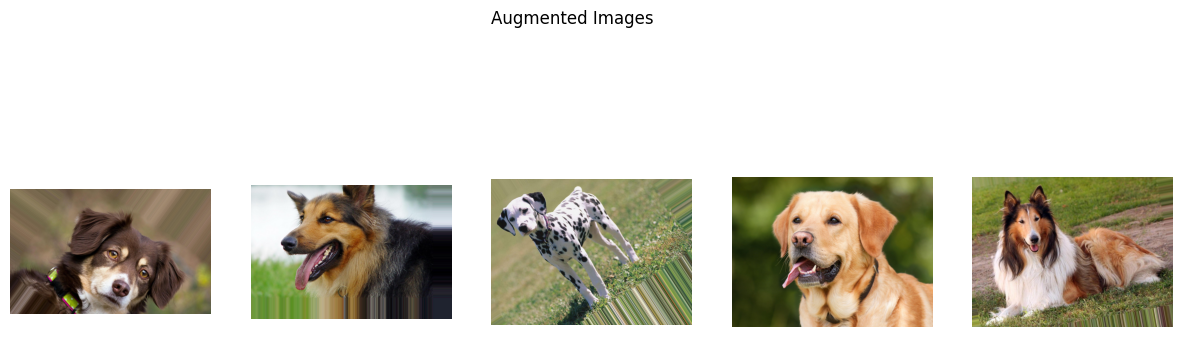

In [ ]:
# Визуализация аугментированных изображений
def display_images(image_dir, num_images=5, title="Images"):
    image_files = os.listdir(image_dir)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(image_files):
        img = Image.open(os.path.join(image_dir, image_file))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_images(os.path.join(augmented_dir, 'images', 'train'), title="Augmented Images")


In [ ]:
# Объединение исходных и аугментированных данных
for folder in ['images', 'labels']:
    for subfolder in ['train']:
        original_folder = os.path.join('yolo_dataset', folder, subfolder)
        augmented_folder = os.path.join(augmented_dir, folder, subfolder)
        for filename in os.listdir(augmented_folder):
            shutil.move(os.path.join(augmented_folder, filename), os.path.join(original_folder, filename))


In [ ]:
# Визуализация изображения
def display_image(image, title="Image"):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

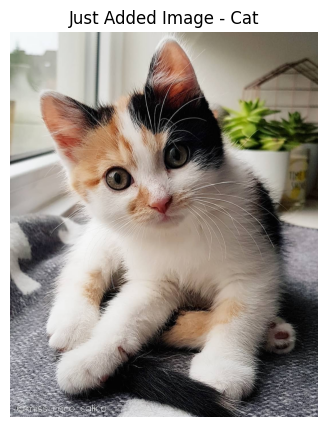

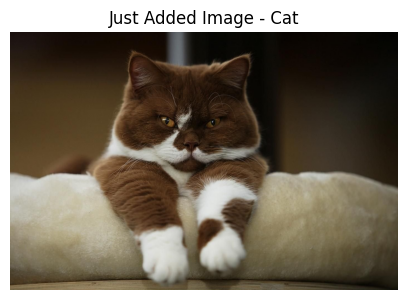

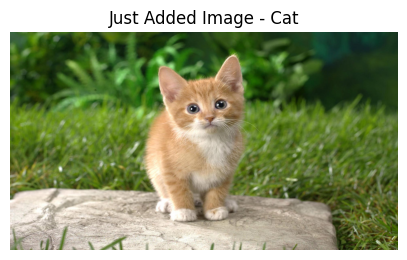

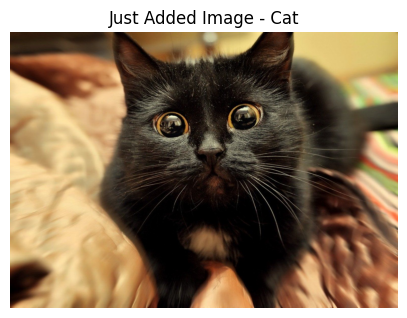

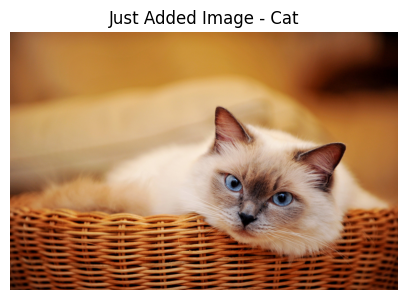

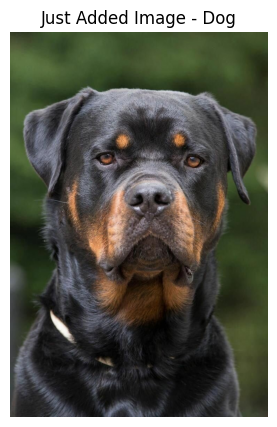

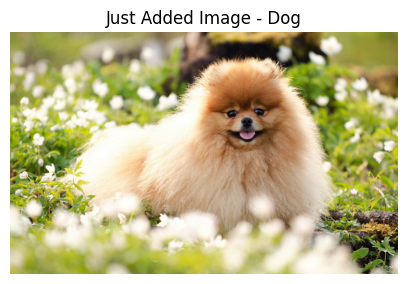

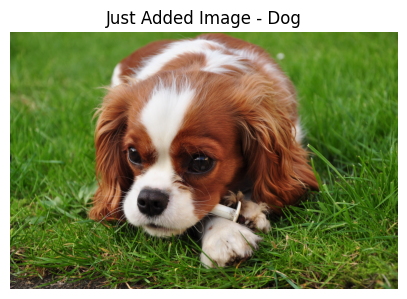

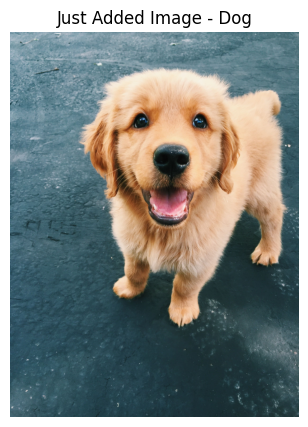

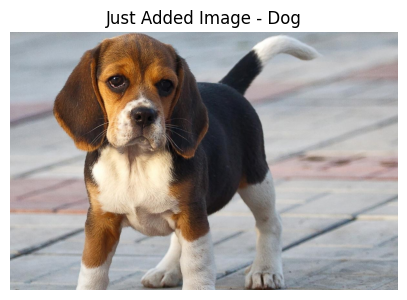

In [ ]:
# Добавление изображений котов и собак без аугментации
just_cats_dir = '/content/drive/MyDrive/images_for_aug/just_cats'
just_dogs_dir = '/content/drive/MyDrive/images_for_aug/just_dogs'

for img_file in os.listdir(just_cats_dir):
    shutil.copy(os.path.join(just_cats_dir, img_file), os.path.join(dataset_dir, 'images', 'train'))
    img = Image.open(os.path.join(dataset_dir, 'images', 'train', img_file))
    display_image(img, 'Just Added Image - Cat')
    img_name = os.path.splitext(img_file)[0]
    with open(os.path.join(dataset_dir, 'labels', 'train', f'{img_name}.txt'), 'w') as f:
        f.write('0 0.5 0.5 1.0 1.0\n')

for img_file in os.listdir(just_dogs_dir):
    shutil.copy(os.path.join(just_dogs_dir, img_file), os.path.join(dataset_dir, 'images', 'train'))
    img = Image.open(os.path.join(dataset_dir, 'images', 'train', img_file))
    display_image(img, 'Just Added Image - Dog')
    img_name = os.path.splitext(img_file)[0]
    with open(os.path.join(dataset_dir, 'labels', 'train', f'{img_name}.txt'), 'w') as f:
        f.write('1 0.5 0.5 1.0 1.0\n')



In [ ]:
# Обучение модели
from ultralytics import YOLO

model = YOLO('yolov8m.pt')  # Загружаем предобученную модель
model.train(data=os.path.join(dataset_dir, 'data.yaml'), epochs=10)

100%|██████████| 49.7M/49.7M [00:00<00:00, 391MB/s]


Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=yolo_dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 755k/755k [00:00<00:00, 44.6MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 16                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192, 192, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  2   1846272  ultralytics.nn.modules.block.C2f             [576, 384, 2]                 
 19                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960,

100%|██████████| 6.23M/6.23M [00:00<00:00, 196MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/yolo_dataset/labels/train... 12102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12102/12102 [00:05<00:00, 2202.07it/s]


train: New cache created: /content/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/yolo_dataset/labels/val... 4512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4512/4512 [00:03<00:00, 1247.05it/s]


val: New cache created: /content/yolo_dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      7.14G      0.182      0.738      0.964          6        640: 100%|██████████| 757/757 [06:52<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:59<00:00,  2.36it/s]

                   all       4512       4512      0.727      0.743      0.806      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         7G     0.1279     0.4773     0.9042          6        640: 100%|██████████| 757/757 [06:40<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:59<00:00,  2.38it/s]

                   all       4512       4512      0.751      0.852      0.868      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      7.09G     0.1073     0.4017      0.896          6        640: 100%|██████████| 757/757 [06:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:58<00:00,  2.43it/s]

                   all       4512       4512      0.882      0.899      0.963       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.98G    0.08716     0.3389     0.8852          6        640: 100%|██████████| 757/757 [06:35<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:57<00:00,  2.44it/s]

                   all       4512       4512      0.858      0.934      0.975      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      7.09G    0.06957     0.2763     0.8752          6        640: 100%|██████████| 757/757 [06:36<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:58<00:00,  2.43it/s]

                   all       4512       4512      0.921      0.939      0.981      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       7.1G    0.06327     0.2459     0.8736          6        640: 100%|██████████| 757/757 [06:33<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:56<00:00,  2.48it/s]

                   all       4512       4512      0.922      0.937      0.984      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       7.1G    0.05378     0.2024     0.8664          6        640: 100%|██████████| 757/757 [06:33<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:57<00:00,  2.47it/s]

                   all       4512       4512      0.933       0.94      0.985      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         7G    0.04518      0.184     0.8644          6        640: 100%|██████████| 757/757 [06:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:58<00:00,  2.42it/s]

                   all       4512       4512       0.95      0.952      0.987      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      7.09G    0.03667     0.1541     0.8624          6        640: 100%|██████████| 757/757 [06:35<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:57<00:00,  2.45it/s]

                   all       4512       4512      0.948      0.957      0.989      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       7.1G    0.02944     0.1306     0.8628          6        640: 100%|██████████| 757/757 [06:33<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:57<00:00,  2.47it/s]

                   all       4512       4512      0.962      0.972      0.991      0.973



10 epochs completed in 1.273 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [01:00<00:00,  2.31it/s]


                   all       4512       4512       0.95      0.951      0.987      0.985
                   cat       2262       2262       0.96      0.934      0.988      0.985
                   dog       2250       2250      0.941      0.968      0.987      0.985
Speed: 0.2ms preprocess, 7.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x783f037f7370>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:

# Оценка модели
metrics = model.val(data=os.path.join(dataset_dir, 'data.yaml'))
print(metrics)


Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/yolo_dataset/labels/val.cache... 4512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4512/4512 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 282/282 [01:37<00:00,  2.90it/s]


                   all       4512       4512      0.942      0.956      0.987      0.983
                   cat       2262       2262      0.957      0.941      0.988      0.984
                   dog       2250       2250      0.927      0.971      0.986      0.982
Speed: 0.2ms preprocess, 17.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x783e956de230>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,   

In [ ]:
# # Визуализация результатов
# results_dir = os.path.join('runs', 'detect', 'exp')
# display_images(results_dir, title="Detection Results")

добавила ниже


In [ ]:
# Визуализация результатов обнаружения на изображениях из датасета и аугментированных изображениях
def visualize_detection_results(model, image_paths, title="Detection Results"):
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(image_paths):
        image = cv2.imread(image_path)
        results = model(image)
        image = results[0].plot()
        plt.subplot(2, 3, i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Image {i+1}")
    plt.suptitle(title)
    plt.show()


In [ ]:
# Список изображений для демонстрации работы модели
sample_image_paths = [train_files[0], train_files[1], train_files[2]]  # 3 изображения из датасета
augmented_image_paths = [os.path.join(dataset_dir, 'images', 'train', filename) for filename in os.listdir(os.path.join(dataset_dir, 'images', 'train'))[:3]]  # 3 аугментированных изображения



0: 576x640 1 dog, 35.7ms
Speed: 5.3ms preprocess, 35.7ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x480 1 dog, 67.0ms
Speed: 2.2ms preprocess, 67.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 1 cat, 80.5ms
Speed: 2.5ms preprocess, 80.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0: 640x448 1 dog, 74.2ms
Speed: 2.3ms preprocess, 74.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 (no detections), 27.5ms
Speed: 3.9ms preprocess, 27.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 dog, 28.8ms
Speed: 4.5ms preprocess, 28.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


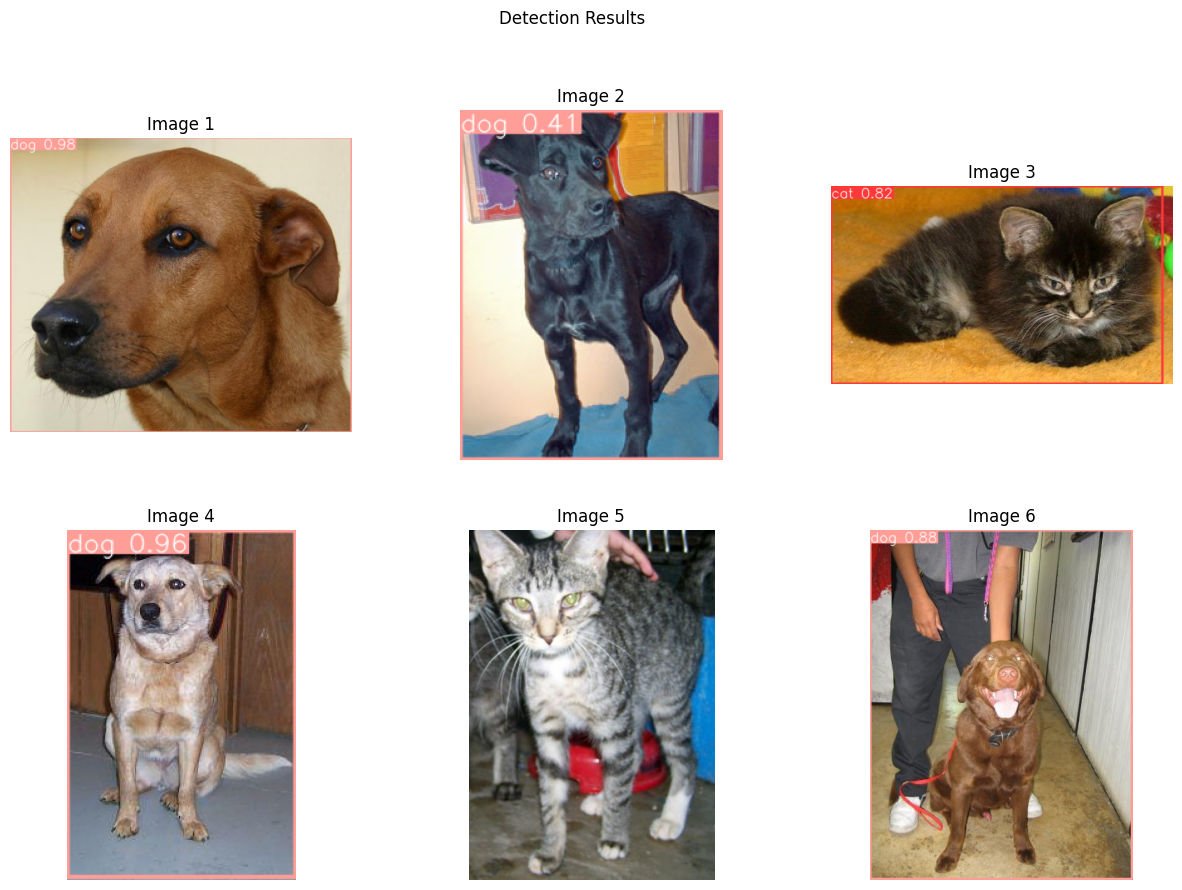

In [ ]:
# Визуализация результатов обнаружения
visualize_detection_results(model, sample_image_paths + augmented_image_paths, title="Detection Results")